In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src')) # include top level package in python path

In [2]:
%env CUDA_LAUNCH_BLOCKING=1
import torch
from torch import nn
from torch.utils.data import DataLoader
from data.data_synth import DNFDataset
from model import fuzzy_logic
from model import embed_logic
from model.fuzzy_layer import FuzzyDNF, FuzzySignedConjunction, FuzzyUnsignedDisjunction
from model.embed_layer import EmbedDNF
from plot import plot_loss, plot_bit_density
from dnf import format_dnf, format_vars
import matplotlib.pyplot as plt

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
%%capture
from tqdm.notebook import tqdm
tqdm().pandas()

In [4]:
#device = 'cpu'
device = 'cuda'

In [50]:
def train_dnf(model: FuzzyDNF, dataloader, lr, log):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.BCELoss()

    seen = 0
    items = []
    obs_losses = []
    props = []
    dnf_strs = []
    prev_dnf_params = None

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        pred = model.logsumexp_forward(X)
        mult = torch.where(y > 0.5, torch.tensor(-1.0).to(device), torch.tensor(1.0).to(device))
        train_loss = (mult * pred).sum()
        #print(model(X).shape, y.shape)
        test_loss = loss_fn(model(X), y)
        # Optimise NN model
        optimizer.zero_grad()
        if log:
            train_loss.backward()
        else:
            (test_loss ** 2).backward()
        optimizer.step()
        
        """
        dnf_params = model.harden_params()
        if prev_dnf_params == None or not all(map(torch.equal, prev_dnf_params, dnf_params)):
            dnf_strs.append(model.params_to_str())
            prev_dnf_params = tuple(map(lambda t: t.clone().detach(), dnf_params))
        """
        seen += len(X)
        items.append(seen)
        obs_losses.append(test_loss.item())
        props.append(y.mean())
        
    return torch.tensor(items), torch.tensor(obs_losses), torch.tensor(props), dnf_strs

In [43]:
dnf_dataset = DNFDataset(10, 100, 0.5, 2, 0.5)
for X, y in dnf_dataset:
    print(format_vars(X))
    print("Given formula:")
    print(format_dnf(dnf_dataset.conj_signs, dnf_dataset.conj_weights))
    print("Produces:")
    print(str(y) + "\n")

( 0 ∧ ¬1 ∧ ¬2 ∧ 3 ∧ 4 ∧ 5 ∧ ¬6 ∧ ¬7 ∧ 8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( 0 ∧ 1 ∧ 2 ∧ ¬3 ∧ 4 ∧ ¬5 ∧ ¬6 ∧ ¬7 ∧ 8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( 0 ∧ ¬1 ∧ 2 ∧ ¬3 ∧ 4 ∧ 5 ∧ ¬6 ∧ 7 ∧ 8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( ¬0 ∧ 1 ∧ ¬2 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ 6 ∧ 7 ∧ ¬8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( ¬0 ∧ ¬1 ∧ 2 ∧ 3 ∧ 4 ∧ 5 ∧ 6 ∧ 7 ∧ ¬8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( 0 ∧ 1 ∧ 2 ∧ 3 ∧ ¬4 ∧ 5 ∧ ¬6 ∧ 7 ∧ 8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( ¬0 ∧ 1 ∧ 2 ∧ 3 ∧ ¬4 ∧ ¬5 ∧ ¬6 ∧ ¬7 ∧ 8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

(

tensor(0.)

( 0 ∧ 1 ∧ 2 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬6 ∧ ¬7 ∧ ¬8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(1.)

( ¬0 ∧ ¬1 ∧ 2 ∧ ¬3 ∧ 4 ∧ ¬5 ∧ 6 ∧ ¬7 ∧ 8 ∧ ¬9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( ¬0 ∧ 1 ∧ ¬2 ∧ ¬3 ∧ 4 ∧ 5 ∧ ¬6 ∧ ¬7 ∧ 8 ∧ ¬9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( 0 ∧ 1 ∧ 2 ∧ ¬3 ∧ 4 ∧ 5 ∧ ¬6 ∧ 7 ∧ ¬8 ∧ 9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)

( 0 ∧ ¬1 ∧ ¬2 ∧ 3 ∧ 4 ∧ ¬5 ∧ 6 ∧ 7 ∧ 8 ∧ ¬9 )
Given formula:
( 2 ∧ ¬3 ∧ ¬5 ∧ ¬6 ∧ 7 ∧ 9 )
∨ ( 0 ∧ 1 ∧ ¬3 ∧ ¬4 ∧ 5 ∧ ¬7 )
Produces:
tensor(0.)



In [44]:
class FuzzyNN(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.logic = fuzzy_logic.ProductLogic()
        self.conjs = FuzzySignedConjunction(
            in_features=in_features, out_features=16, logic=self.logic
        )
        self.disj = FuzzyUnsignedDisjunction(
            in_features=16, out_features=1, logic=self.logic,
        )
        self.model = nn.Sequential(
            self.conjs,
            self.disj
        )
        self.logsumexp = nn.Sequential(
            self.conjs,
        )

    def forward(self, input):
        return self.model(input).squeeze()
            
    def logsumexp_forward(self, input):
        return self.conjs(input).logsumexp(dim=-1)

  0%|          | 0/1563 [00:00<?, ?it/s]

[]


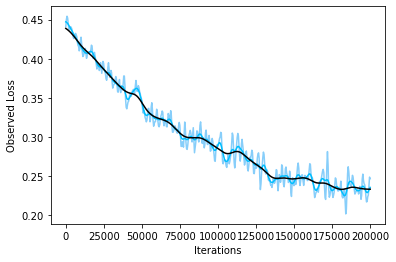

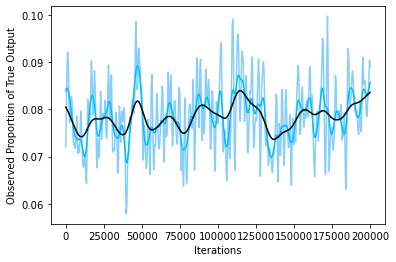

In [51]:
dnf_dim = 10
dnf_dataset = DNFDataset(dnf_dim, 200000, 0.5, 2, 0.5)
dnf_dataloader = DataLoader(dnf_dataset, batch_size=128, shuffle=True)

dnf_model = FuzzyNN(dnf_dim)
dnf_model.to(device)

dnf_items, dnf_losses, dnf_props, dnf_strs = train_dnf(dnf_model, dnf_dataloader, lr=1e-3, log=True)

print(dnf_strs)

plot_loss(dnf_items, dnf_losses, ylabel='Observed Loss', approx=True)
plot_loss(dnf_items, dnf_props, ylabel='Observed Proportion of True Output', approx=True)

  0%|          | 0/1563 [00:00<?, ?it/s]

[]


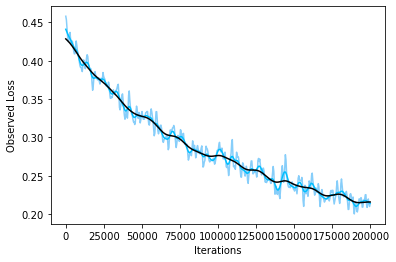

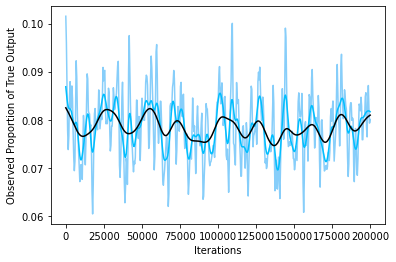

In [52]:
dnf_model = FuzzyNN(dnf_dim)
dnf_model.to(device)

dnf_items, dnf_losses, dnf_props, dnf_strs = train_dnf(dnf_model, dnf_dataloader, lr=1e-3, log=False)

print(dnf_strs)

plot_loss(dnf_items, dnf_losses, ylabel='Observed Loss', approx=True)
plot_loss(dnf_items, dnf_props, ylabel='Observed Proportion of True Output', approx=True)

In [17]:
class PerceptronDNF(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
dnf_dim = 10
dnf_dataset = DNFDataset(dnf_dim, 200000, 0.5, 2, 0.5)
dnf_dataloader = DataLoader(dnf_dataset, batch_size=128, shuffle=True)

dnf_model = PerceptronDNF(dnf_dim)
dnf_model.to(device)

dnf_items, dnf_losses, dnf_props, dnf_strs = train_dnf(dnf_model, dnf_dataloader, lr=5e-4)

print(dnf_strs)

plot_loss(dnf_items, dnf_losses, ylabel='Observed Loss', approx=True)
plot_loss(dnf_items, dnf_props, ylabel='Observed Proportion of True Output', approx=True)

In [ ]:
def train_embed_dnf(model: nn.Module, dataloader, optim, reg_weight=1e-2):
    loss_fn = torch.nn.BCELoss()

    seen = 0
    items = []
    obs_losses = []
    props = []

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        pred = torch.squeeze(model(X))
        loss = loss_fn(pred, y)

        # Optimise NN model
        optim.zero_grad()
        (loss + reg_weight * model.logic.logic_reg()).backward()
        optim.step()
        model.logic.zero_reg()
        
        seen += len(X)
        items.append(seen)
        obs_losses.append(loss.item())
        props.append(y.mean())
        
    return torch.tensor(items), torch.tensor(obs_losses), torch.tensor(props)

In [ ]:
class EmbedNN(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.logic = embed_logic.EmbedLogic(5, calculate_reg=False)
        self.logic2 = embed_logic.EmbedLogic(5, calculate_reg=False)
        self.model = nn.Sequential(
            EmbedDNF((in_features, 16, 8), logic=self.logic),
            EmbedDNF((8, 16, 1), logic=self.logic2),
        )

    def forward(self, input):
        return self.logic.decode(self.model(self.logic.encode(input)))

In [ ]:
embed_input_dim = 10
embed_dataset = DNFDataset(embed_input_dim, 150000, 0.5, 2, 0.5)
embed_dataloader = DataLoader(embed_dataset, batch_size=128, shuffle=True)

embed_model = EmbedNN(embed_input_dim)
embed_model.to(device)
embed_optimizer = torch.optim.Adam(embed_model.parameters(), lr=1e-4)

embed_items, embed_losses, embed_props = train_embed_dnf(embed_model, embed_dataloader, embed_optimizer, 0)
#dnf_items2, dnf_losses2, dnf_props2, _ = train_dnf(dnf_model, dnf_dataloader, lr=1e-4)

#dnf_items = torch.cat((dnf_items, dnf_items.max() + dnf_items2), dim=0)
#dnf_losses = torch.cat((dnf_losses, dnf_losses2), dim=0)
#dnf_props = torch.cat((dnf_props, dnf_props2), dim=0)

plot_loss(embed_items, embed_losses, ylabel='Observed Loss', approx=True)
plot_loss(embed_items, embed_props, ylabel='Observed Proportion of True Output', approx=True)

dnf_model.logic

In [ ]:
embed_model.logic.neg(embed_model.logic.F())

In [ ]:
dnf_losses[-1]

In [ ]:
embed_model.logic.F()

In [ ]:
embed_model.logic._not.w_1

In [ ]:
embed_model.logic._not.b_1

In [ ]:
embed_model.logic._not.w_2